# Optimization WFA - Support Vector Regression

## Support Vector Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


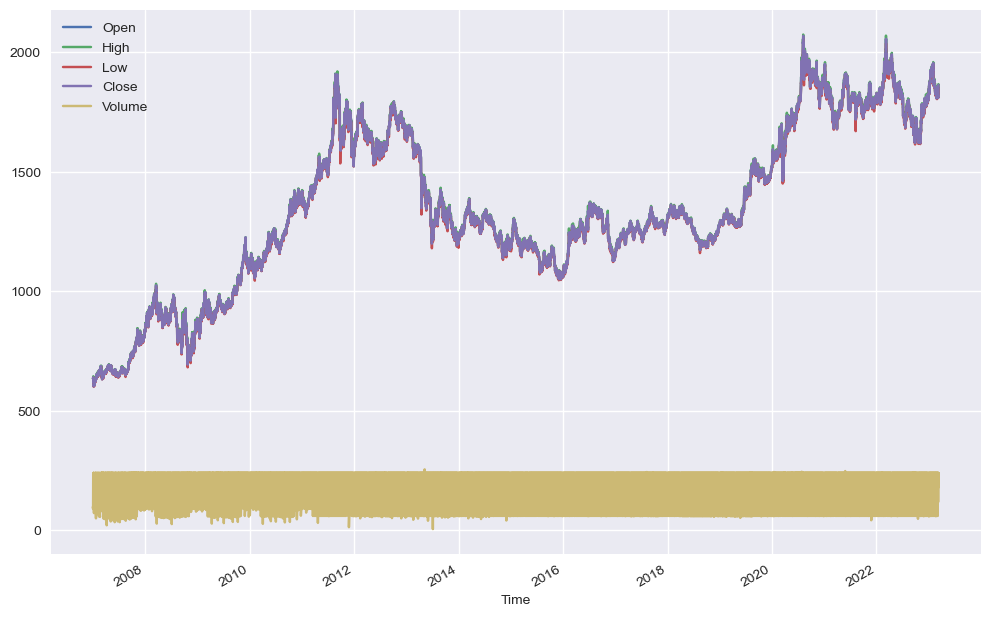

In [10]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [8]:
class Support_Vector_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [9]:
mainFolder = 'Machine_Learning'
strategy = Support_Vector_Regression
strategyName = 'Support_Vector_Regression'
account_size = 10000
folder_ML_Strategy = 'Support Vector Regression'
subFolder = 'Optimization'

In [10]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, future_days=1):
        df = self.data.loc[self.start_train:self.end_train].copy()

        target_col = f"{future_days}_Day_Price_Forecast"
        df[target_col] = df['Close'].shift(-future_days)

        # Drop rows with NaN in the newly created column
        # df.dropna(subset=[target_col], inplace=True)
        df.fillna(0, inplace=True)

        df['pred'] = 0

        model = SVR(kernel='rbf', C=1e3, gamma=0.00001)

        for i in range(self.window_size, len(df)):
            rolling_window_data = df.iloc[i - self.window_size:i]

            # Features (Close price as input)
            features = rolling_window_data[['Close']].copy()
            target = rolling_window_data[target_col].copy()

            model.fit(features, target)

            # Predict for the next data point
            pred_value = model.predict(
                np.array(df['Close'].iloc[i]).reshape(1, -1))
            df.at[df.index[i], 'pred'] = np.where(
                (pred_value > df['Close'][i]), 1, -1)

        self.data_train = df

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   94.983145
Equity Final [$]                  9750.492281
Equity Peak [$]                  10322.131334
Return [%]                          -2.495077
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.126182
Volatility (Ann.) [%]                2.065976
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.352106
Avg. Drawdown [%]                    -1.24135
Max. Drawdown Duration     2847 days 00:00:00
Avg. Drawdown Duration      244 days 00:00:00
# Trades                                  420
Win Rate [%]                             60.0
Best Trade [%]                      12.991396
Worst Trade [%]                    -25.130618
Avg. Trade [%]                    

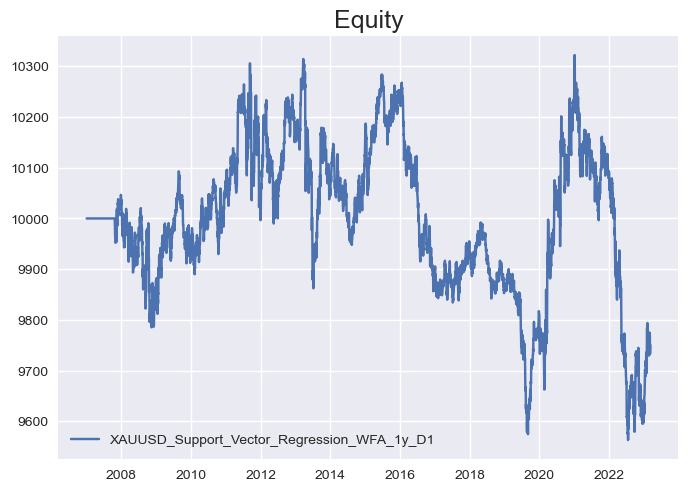

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   89.986119
Equity Final [$]                 10411.206749
Equity Peak [$]                  10644.497708
Return [%]                           4.112067
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.201572
Volatility (Ann.) [%]                2.007649
Sharpe Ratio                         0.100402
Sortino Ratio                        0.141278
Calmar Ratio                         0.022603
Max. Drawdown [%]                   -8.917897
Avg. Drawdown [%]                    -0.51082
Max. Drawdown Duration     4376 days 00:00:00
Avg. Drawdown Duration      106 days 00:00:00
# Trades                                  281
Win Rate [%]                        67.615658
Best Trade [%]                      17.887812
Worst Trade [%]                    -30.041882
Avg. Trade [%]                    

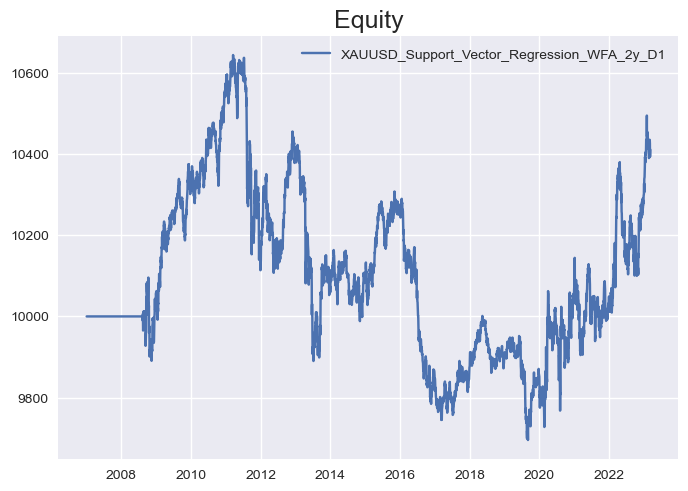

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   84.989094
Equity Final [$]                 10417.971055
Equity Peak [$]                  10501.971062
Return [%]                           4.179711
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.204824
Volatility (Ann.) [%]                1.964573
Sharpe Ratio                         0.104259
Sortino Ratio                        0.146485
Calmar Ratio                         0.032783
Max. Drawdown [%]                   -6.247824
Avg. Drawdown [%]                   -0.510376
Max. Drawdown Duration     4015 days 00:00:00
Avg. Drawdown Duration      157 days 00:00:00
# Trades                                  230
Win Rate [%]                        71.304348
Best Trade [%]                       7.084544
Worst Trade [%]                    -25.440683
Avg. Trade [%]                    

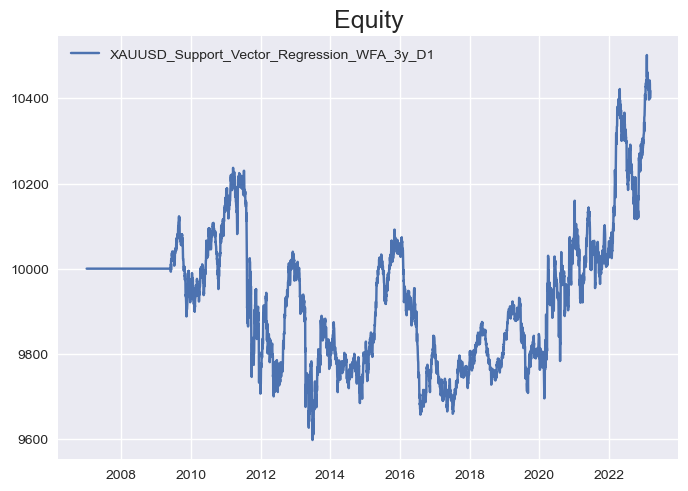

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   79.992068
Equity Final [$]                 10135.935557
Equity Peak [$]                  10334.025028
Return [%]                           1.359356
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.067493
Volatility (Ann.) [%]                 1.95273
Sharpe Ratio                         0.034563
Sortino Ratio                        0.048445
Calmar Ratio                         0.007179
Max. Drawdown [%]                   -9.401832
Avg. Drawdown [%]                   -0.548811
Max. Drawdown Duration     4376 days 00:00:00
Avg. Drawdown Duration      163 days 00:00:00
# Trades                                  235
Win Rate [%]                        65.106383
Best Trade [%]                       9.280735
Worst Trade [%]                    -26.713747
Avg. Trade [%]                    

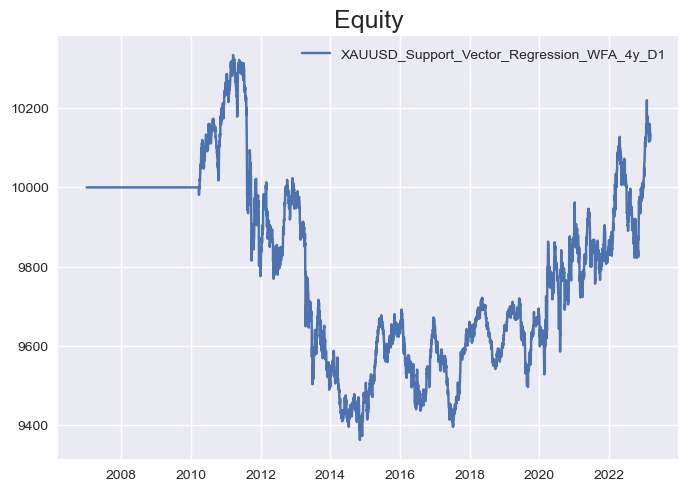

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   74.995043
Equity Final [$]                 10324.377652
Equity Peak [$]                  10408.377659
Return [%]                           3.243777
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.159646
Volatility (Ann.) [%]                1.932793
Sharpe Ratio                         0.082599
Sortino Ratio                        0.115339
Calmar Ratio                         0.018617
Max. Drawdown [%]                   -8.575275
Avg. Drawdown [%]                   -1.051471
Max. Drawdown Duration     3582 days 00:00:00
Avg. Drawdown Duration      261 days 00:00:00
# Trades                                  181
Win Rate [%]                         69.61326
Best Trade [%]                      10.467915
Worst Trade [%]                    -25.110946
Avg. Trade [%]                    

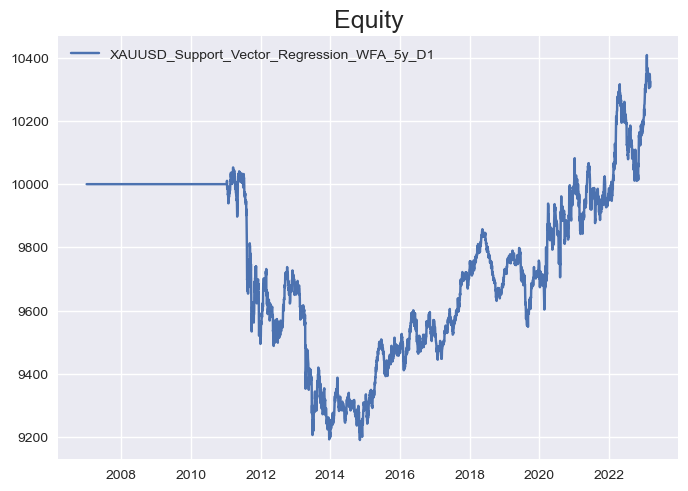

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   69.998017
Equity Final [$]                 10697.709937
Equity Peak [$]                  10781.709944
Return [%]                           6.977099
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.337591
Volatility (Ann.) [%]                1.730564
Sharpe Ratio                         0.195076
Sortino Ratio                        0.275571
Calmar Ratio                         0.059086
Max. Drawdown [%]                   -5.713579
Avg. Drawdown [%]                   -0.890064
Max. Drawdown Duration     1783 days 00:00:00
Avg. Drawdown Duration      133 days 00:00:00
# Trades                                  151
Win Rate [%]                        78.145695
Best Trade [%]                       8.579059
Worst Trade [%]                    -26.197815
Avg. Trade [%]                    

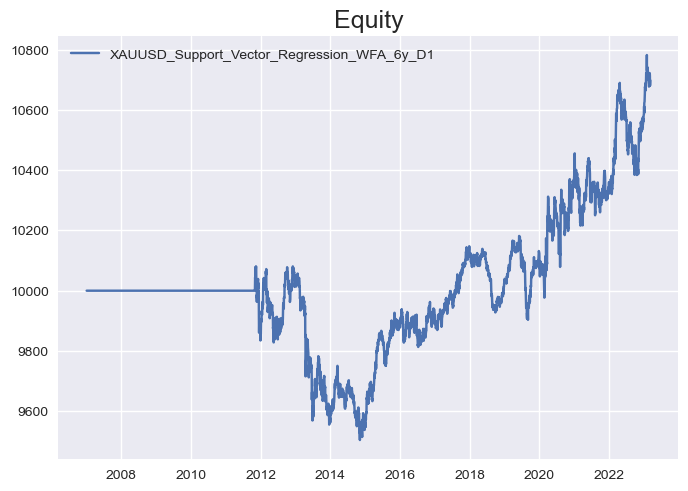

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   65.000991
Equity Final [$]                 10348.165948
Equity Peak [$]                  10432.165955
Return [%]                           3.481659
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.171166
Volatility (Ann.) [%]                1.659379
Sharpe Ratio                          0.10315
Sortino Ratio                        0.145988
Calmar Ratio                         0.023737
Max. Drawdown [%]                   -7.210777
Avg. Drawdown [%]                    -0.67661
Max. Drawdown Duration     3388 days 00:00:00
Avg. Drawdown Duration      192 days 00:00:00
# Trades                                  133
Win Rate [%]                         75.18797
Best Trade [%]                       9.426544
Worst Trade [%]                    -26.393151
Avg. Trade [%]                    

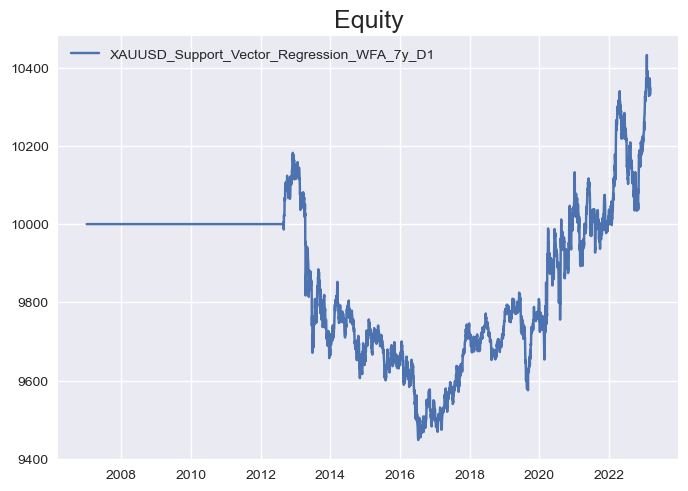

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   60.003966
Equity Final [$]                 10880.249894
Equity Peak [$]                  10964.249901
Return [%]                           8.802499
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                     0.42246
Volatility (Ann.) [%]                1.500385
Sharpe Ratio                         0.281567
Sortino Ratio                         0.41476
Calmar Ratio                         0.130087
Max. Drawdown [%]                   -3.247525
Avg. Drawdown [%]                   -0.562547
Max. Drawdown Duration      987 days 00:00:00
Avg. Drawdown Duration       72 days 00:00:00
# Trades                                  121
Win Rate [%]                        73.553719
Best Trade [%]                       9.426544
Worst Trade [%]                    -13.016303
Avg. Trade [%]                    

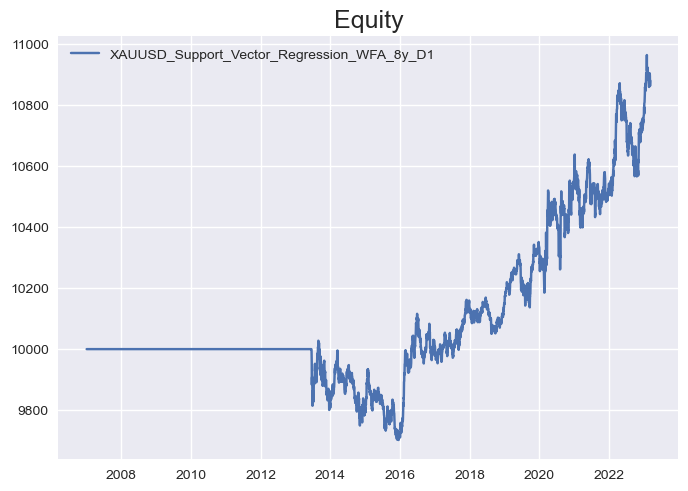

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [11]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   94.175393
Equity Final [$]                  8345.147629
Equity Peak [$]                  10016.297584
Return [%]                         -16.548524
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.899912
Volatility (Ann.) [%]                 2.22234
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -17.607304
Avg. Drawdown [%]                   -3.605725
Max. Drawdown Duration     5553 days 16:00:00
Avg. Drawdown Duration     1114 days 12:00:00
# Trades                                 1022
Win Rate [%]                        55.283757
Best Trade [%]                       8.713051
Worst Trade [%]                    -15.137182
Avg. Trade [%]                    

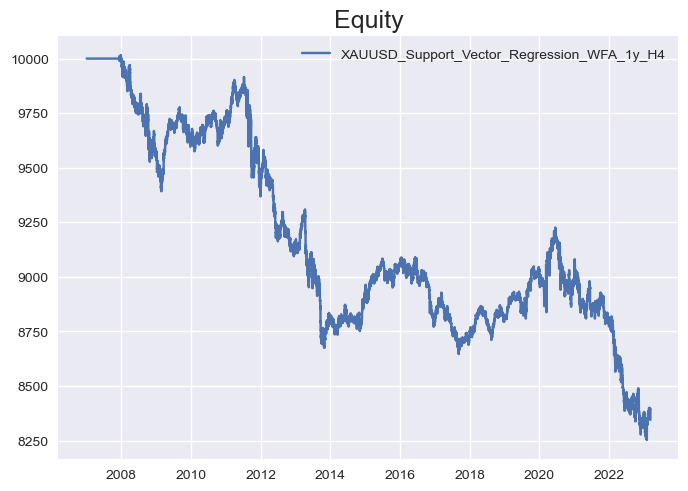

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [12]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

KeyboardInterrupt: 

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train,
                   end_train, TF, window_size,account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')